## Einstein Omics Workshop: Ancestry Analysis Tutorial 
**Author**: David Yang<br>
**Laboratory**: Sri Raj and John Greally<br>
**Date**: February 2024

***
<div class="alert alert-block alert-warning">
<b>README:</b> 
Select Kernel: "conda env:omics-workshop-python". It is crucial for the tutorial's execution that all associated scripts are located in the same directory. 
To successfully complete the tutorial, execute all commands in sequence.  For more information about the files needed, please refer to the README.
    
</div>
<div class="alert alert-block alert-warning">
<b>Note:</b> There are two versions of PLINK (1.9 or 2), depending on the function we will be using one or the other.
    The "!" is a command that allows to run a command line package on Jupyter
</div>

***

### Ancestry Analysis Tutorial
Analysis of population structure is a pre-requisite for association studies between human genetic variants and phenotypes (ex: [(Genome Wide Association Study (GWAS) for Type 2 Diabetes)](https://www.nature.com/articles/s41597-020-00716-7) to control for genetic differences from ancestry. This vignette will cover principal components analysis (PCA) and admixture analysis, which are techniques used by population geneticists to understand patterns of genetic variation seen across human populations. We will start by preparing our datasets using multiple quality control thresholds, then we will run the analyses and vizualize the results generated along the way.

**Outline:** <br>
    1) Prepare the query dataset: Single nucleotide polymorphisms (SNPs) from the International HapMap Project. <br>
    2) Prepare the reference dataset: SNPs from the 1000 Genomes Project.<br>
    3) Merge the query and reference SNPs.<br>
    4) Principal Components Analysis.<br>
    5) Admixture Analysis. (💡 Not in this vignette)<br>

<div>
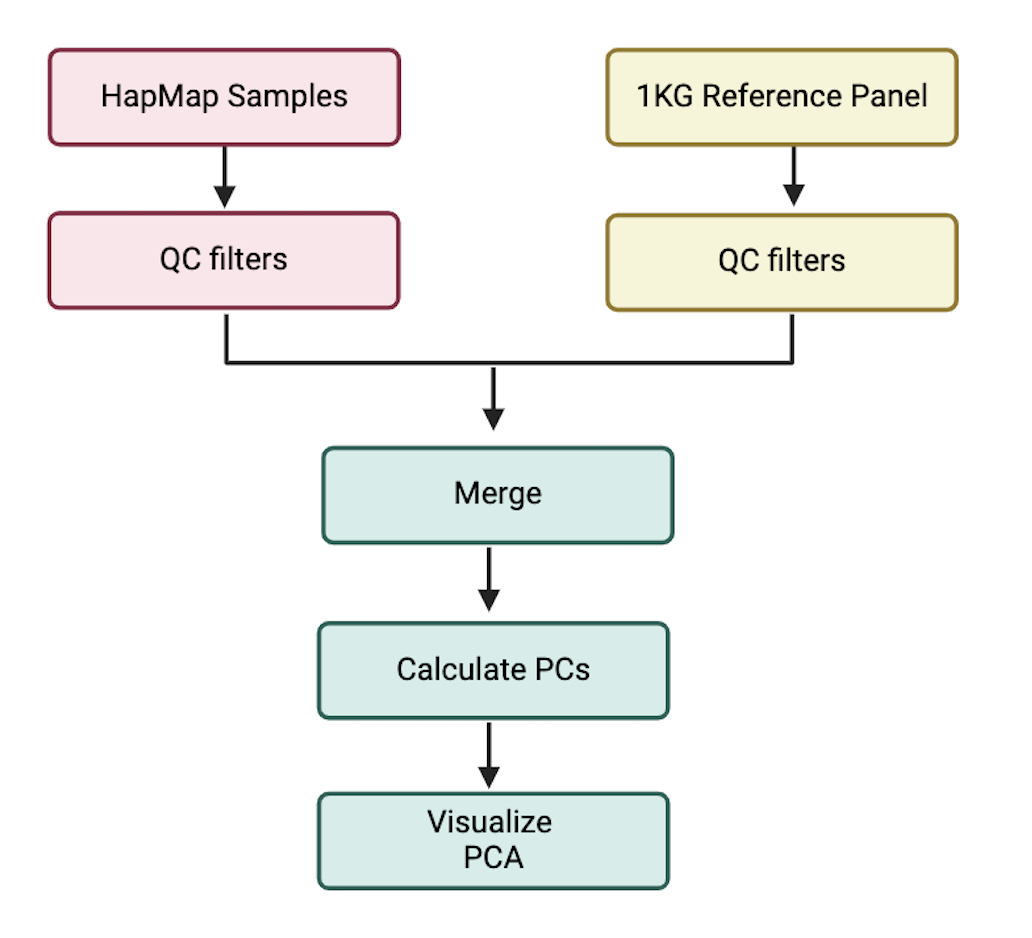
</div>

#### Background

Population geneticists study the genetic variation within and between populations to unravel the forces shaping evolutionary processes. One crucial aspect of this research is the analysis of population stratification (PS) – the distribution and composition of genetic variation among subpopulations within a broader population. PS of human populations occurs due to multiple factors: non-random mating, geographic isolation of subpopulations with low rates of migration, and gene flow over many generations.

When analyzing human genomic datasets, population stratification can confound association studies seeking to link genetic variants with specific traits or diseases. Correcting for population stratification using the methods discussed in this tutorial (Principal Components Analysis (PCA) and Admixture Analysis) can be used to ensure that observed associations are not artifacts of underlying population differences in the distribution and composition of genetic variation. By analyzing human genetic data, we can quantify allele frequencies of genetic variants and use a reference dataset to relate these patterns to genetic ancestry.

Using these data, we will also quantify admixture, the mixing of individuals or populations of different ancestry. In human populations, admixture can be a consequence of historical events such as migrations, conquests, or the diaspora of groups across geographic regions. Understanding admixture is crucial in genetic association studies, as it can influence the distribution of genetic traits and impact the interpretation of genetic studies. Analyzing patterns of admixture can also provide insights into the demographic history, migration patterns, and genetic diversity of populations.

#### An example case of the potential pitfalls of population structure in case-control studies:

"When cases and controls have different allele frequencies attributable to diversity in background population, unrelated to outcome status, a study is said to have population stratification." [(Cardon and Palmer, 2003)](https://pubmed.ncbi.nlm.nih.gov/12598158/)

This [example (Knowler et al., 1988)](https://www.researchgate.net/profile/Robert-Williams-52/publication/19979684_Gm351314_and_type_2_diabetes_mellitus_An_association_in_American_Indians_with_genetic_admixture/links/5b14966e4585150a0a669330/Gm35-13-14-and-type-2-diabetes-mellitus-An-association-in-American-Indians-with-genetic-admixture.pdf) highlights how PS can lead to spurious associations when genetic ancestry is linked with both the disease/trait and the genetic marker under scrutiny. In this logintudinal study of type 2 diabetes in 4,920 Native Americans of the Pima and Papago tribes, the authors demonstrate how an inverse association between the Gm3;5,13,14 haplotype and a type 2 diabetes mellitus (T2D) (prevalence ratio = 0.27, 95% CI=0.18-0.40) can be found when NOT accounting for genetic ancestry. This would lead to the false conclusion that the haplotype acts to or is closely linked to a locus that decreases the risk for T2D. However, when accounting accounting for ancestry (by self-reported ancestry and family records) this association was not seen.

- The Gm3;5,13,14 haplotype haplotype has a very low frequency among full-heritage Pima and Papago Indians (0.006 in each group), but a high frequency in Caucasian Europeans (0.665).
- T2D is more prevalent in Native Americans (~40%) than in Europeans (~15%).).
- The inverse association between the Gm3;5,13,14 haplotype and T2DM is attributable to ancestral population of origin rather than to
linkage disequilibrium between the disease and marker loci.
-  The Gm3;5,13,14 haplotype serves as a marker of admixture between Native Americans and Europeans.


Learn more here: [Assessing the impact of population stratification on genetic association studies](https://www.nature.com/articles/ng1333)

### Quality Control using PLINK Software
***
This tutorial has been adapted from Andries T. Marees [(github)](https://github.com/MareesAT/GWA_tutorial/)
***
In this tutorial, we will be conducting our genetic analysis using a software called PLINK. *Genetic ancestry analysis* involves a comprehensive quality control (QC) process to ensure the accuracy and reliability of results. QC is essential for identifying and mitigating potential issues arising from genotyping errors, sample contamination, and other data anomalies. [PLINK](https://www.cog-genomics.org/plink/1.9/) provides a robust set of tools to assess and process genetic data.

The dataset used in this tutorial was generated using publicly available data from the International HapMap Project (hapmap3_r3_b36_fwd.consensus.qc.). The data is stored in [PLINK binary format](https://www.cog-genomics.org/plink/1.9/input#bed) which is composed of three files with the same name, but different extention (*.fam, *.bed, *.bim). 

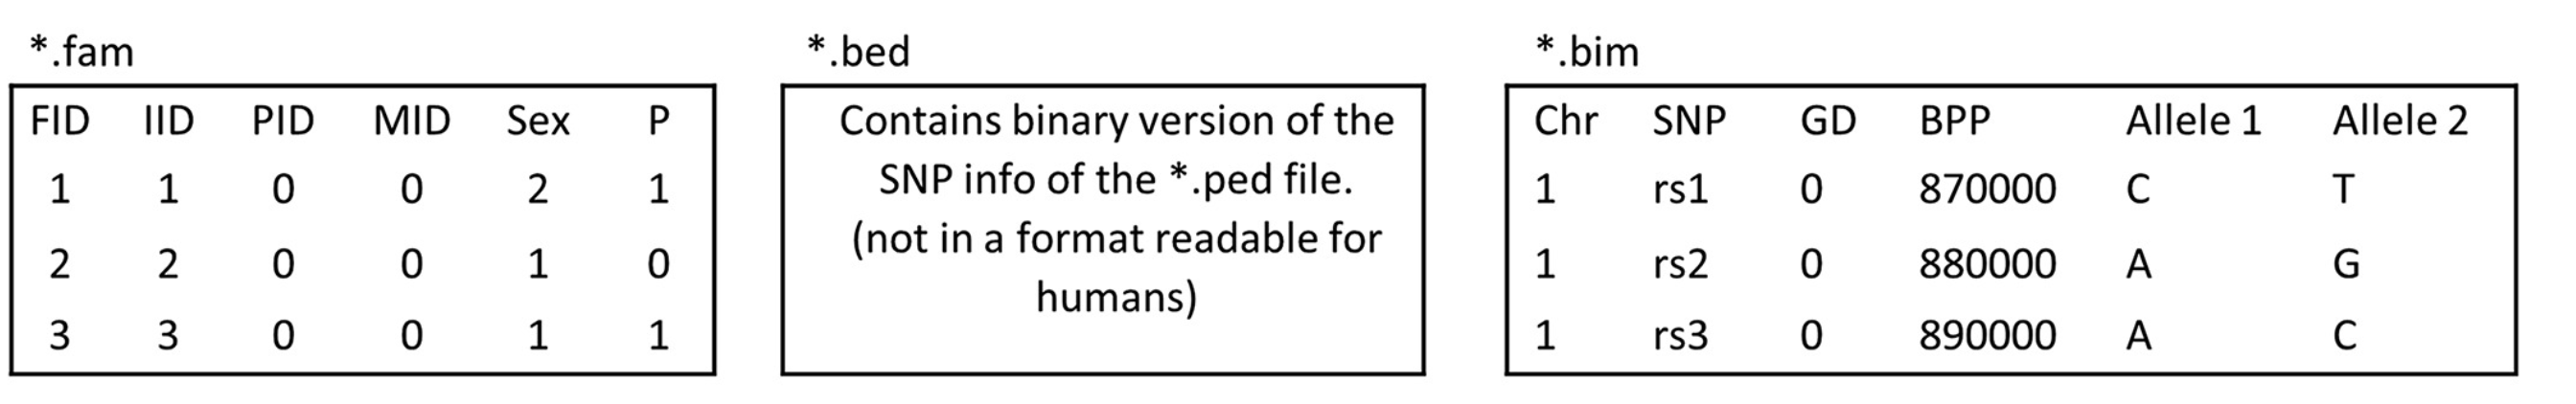

- *.fam: contains individual's and familyinformation
- *.bed: contains the individual's genotypes
- *.bim: contains the genetic variant infomation (ex. chr, position, Ref/Alt alleles)


Phenotypic information for these samples was simulated for a simulated binary outcome measure, representing a binary phenotypic trait. The simulated outcome measure was exclusively applied to the founders in the HapMap data (file name:HapMap_3_r3_1). The QC steps covered in this next section will work through a number of QC steps to comprehensively process genetic data for downstream applications such as genome wide association studies (GWAS) or population structure analysis.

Most GWAS studies focus on ethnically homogenous populations, excluding population outliers. The HapMap data used in this tutorial encompasses multiple distinct ethnic groups, posing challenges for analysis. Therefore, we have specifically chosen only the EUR (European) individuals from the entire HapMap sample for the first part of this tutorial. 


For a comprehensive theoretical understanding of all QC (Quality Control) steps, we recommend referring to the accompanying article: [A tutorial on conducting Genome-Wide-Association Studies: Quality control and statistical analysis](https://www.ncbi.nlm.nih.gov/pubmed/29484742).

**Key QC steps that will be covered:** 

1) Evaluate individual and SNP missingness
2) Identify inconsistencies in reported vs. genetic sex of subjects  
3) Filter by minor allele frequency (MAF) 
4) Identify deviations from Hardy–Weinberg equilibrium (HWE) 
5) Calulcate heterozygosity rate 
6) Identify related samples
7) Identify outliers 

### Step 1: Let's start by taking a look at the contents of our dataset using [PLINK](https://www.cog-genomics.org/plink/1.9/).


In [ ]:
!mkdir results

In [ ]:
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --freq -out results/HapMap_3_r3_1.freq --memory 120000

<code style="background:yellow;color:black">Understanding PLINK output</code>


1. `1457897 variants loaded from .bim file.`: Indicates that PLINK has loaded 1,457,897 genetic variants (SNPs, indels, etc.) from the .bim file, which typically contains information about the markers in a genetic dataset.

2. `165 people (80 males, 85 females) loaded from .fam.`: PLINK has loaded data on 165 individuals from the .fam file, which usually contains information about individuals in a genetic dataset. Here, it shows that there are 80 males and 85 females.

3. `112 phenotype values loaded from .fam.`: Indicates that PLINK has loaded phenotype values for 112 individuals from the .fam file. Phenotype values could represent various traits, conditions, or characteristics for each individual.

4. `Using 1 thread (no multithreaded calculations invoked).`: PLINK is configured to use a single thread for calculations. PLINK can be parallelized to speed up computations, but in this case, it's running in single-threaded mode.

5. `Before main variant filters, 112 founders and 53 nonfounders present.`: Shows the number of founders (individuals with known parents) and non-founders (individuals without known parents) in the dataset.
- Number of Founders (112): These are individuals who are considered the starting point of their respective family trees within the dataset.
- Number of Non-founders (53): These are individuals who have parents present in the dataset.

6. `Warning: 225 het. haploid genotypes present (see HapMap_3_r3_1.freq.hh ); many commands treat these as missing.`: Indicates a warning that 225 heterozygous haploid genotypes are present. Some PLINK commands might treat these as missing data.

7. `Total genotyping rate is 0.997378.`: Shows the overall genotyping rate, indicating the proportion of successfully genotyped markers across all individuals.

8. `--freq: Allele frequencies (founders only) written to HapMap_3_r3_1.freq.frq .`: Informs that PLINK has written allele frequencies (for founders only) to the specified output file, HapMap_3_r3_1.freq.frq.

Let's move onto processing the data using PLINK's quality control filters.

### Step 2: Investigate missingness per individual and per SNP and make histograms.
The initial step in all data analysis is to exclude individuals and SNPs with too much missing genotype data. 

- Input: HapMap_3_r3_1
- Output: plink.imiss and plink.lmiss, these files show respectively the proportion of missing SNPs per individual and the proportion of missing individuals per SNP.


In [ ]:
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --missing --out results/HapMap

Most samples and SNPs have a very low missingness rate!

#### 2.1 Remove SNPs and individuals with high levels of missingness
These steps will remove individuals from our dataset that have low genotype calls.
There are 2 filters that can be applied:
- --geno -> filter SNPs with low genotype calls.
- --mind -> filter individuals with low genotype calls.

 *SNP filtering should be performed before individual filtering.

In [ ]:
# Remove individuals with missingness >0.2. (No one should be removed, we are using a very relaxed threshold of genotype missingness in this first example)
# To include only SNPs with a 80% genotyping rate (20% missing) use
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/HapMap_3_r3_1 --geno 0.2 --make-bed --out results/HapMap_3_r3_2

In [ ]:
# Remove individuals with missingness >0.2.
# exclude with more than 20% missing genotype
!plink --bfile results/HapMap_3_r3_2 --mind 0.2 --make-bed --out results/HapMap_3_r3_3

In [ ]:
# Remove SNPs with missingness >0.02.
!plink --bfile results/HapMap_3_r3_3 --geno 0.02 --make-bed --out results/HapMap_3_r3_4

In [ ]:
# Remove individuals with missingness >0.02.
!plink --bfile results/HapMap_3_r3_4 --mind 0.02 --make-bed --out results/HapMap_3_r3_5

### Step 3: Identify inconsistencies in reported vs. genetic sex of subjects  

Subjects who were a priori determined as females should have a F value of <0.2, and subjects who were a priori determined as males must have a F value >0.8. This F value is based on the X chromosome homozygosity estimate.
Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.



In [ ]:
# Check for sex discrepancy
!plink --bfile results/HapMap_3_r3_5 --check-sex --out results/sex_check

These checks indicate that there is one woman with a sex discrepancy, F=0.99. The following command can be used to deal with individuals with a sex discrepancy.


In [ ]:
# This command generates a list of individuals with the "PROBLEM" status
!grep "PROBLEM" results/sex_check.sexcheck| awk '{print$1,$2}'> txt_files/sex_discrepancy.txt

# This command removes the list of individuals with the status
!plink --bfile results/HapMap_3_r3_5 --remove txt_files/sex_discrepancy.txt --make-bed --out results/HapMap_3_r3_6 


### Step 4: Filter by MAF


In [ ]:
# Generate a bfile with autosomal SNPs only and delete SNPs with a low minor allele frequency (MAF).
# Select autosomal SNPs only (i.e., from chromosomes 1 to 22).
!awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' results/HapMap_3_r3_6.bim > txt_files/snp_1_22.txt
!plink --bfile results/HapMap_3_r3_6 --extract txt_files/snp_1_22.txt --make-bed --out results/HapMap_3_r3_7

In [ ]:
# Generate a plot of the MAF distribution.
!plink --bfile results/HapMap_3_r3_7 --freq --out MAF_check

#### 4.1 Visualize the Minor Allele Frequencies 


In [ ]:
%run MAF_check.py

#### 4.2 Remove SNPs with a low MAF frequency.

In [ ]:
!plink --bfile results/HapMap_3_r3_7 --maf 0.05 --make-bed --out results/HapMap_3_r3_8 --memory 120000
# 1073226 SNPs are left
# A conventional MAF threshold for a regular GWAS is between 0.01 or 0.05, depending on sample size.

### Step 5: Identify deviations from Hardy–Weinberg equilibrium (HWE) 


#### 5.1 Visualize Hardy–Weinberg equilibrium (HWE) distribution

In [ ]:
# Check the distribution of HWE p-values of all SNPs.
! plink --bfile results/HapMap_3_r3_8 --hardy

In [ ]:
# Select SNPs with HWE p-value below 0.00001, required for one of the two plots generated by the next script, allows to zoom in on strongly deviating SNPs. 
!awk '{ if ($9 <0.00001) print $0 }' plink.hwe>plinkzoomhwe.hwe

In [ ]:
%run HWE.py

#### 5.2 Remove SNPs which are not in Hardy-Weinberg equilibrium (HWE).


In [ ]:
# By default the --hwe option in plink only filters for controls.
# Therefore, we use two steps, first we use a stringent HWE threshold for controls, followed by a less stringent threshold for the case data.
!plink --bfile results/HapMap_3_r3_8 --hwe 1e-6 --make-bed --out results/HapMap_hwe_filter_step1

In [ ]:
# The HWE threshold for the cases filters out only SNPs which deviate extremely from HWE. 
# This second HWE step only focusses on cases because in the controls all SNPs with a HWE p-value < hwe 1e-6 were already removed
!plink --bfile results/HapMap_hwe_filter_step1 --hwe 1e-10 --hwe-all --make-bed --out results/HapMap_3_r3_9

### Step 6: Calculate heterozygosity rate 


In [ ]:
# Generate a plot of the distribution of the heterozygosity rate and remove individuals with a heterozygosity rate deviating more than 3 standard deviations from the mean.
# Check for heterozygosity are performed on a set of SNPs which are not highly correlated.
# Therefore, to generate a list of non-(highly)correlated SNPs, we exclude high inversion regions (inversion.txt [High LD regions]) and prune the SNPs using the command --indep-pairwise�.
# The parameters "50 5 0.2" stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.

!plink --bfile results/HapMap_3_r3_9 --exclude txt_files/inversion.txt --range --indep-pairwise 50 5 0.2 --out results/indepSNP

In [ ]:
#This file contains your pruned data set.
!plink --bfile results/HapMap_3_r3_9 --extract results/indepSNP.prune.in --het --out results/het_check

In [ ]:
# The following code generates a list of individuals who deviate more than 3 standard deviations from the heterozygosity rate mean.
%run heterozygosity_outliers_list

#### 6.1 Remove individuals with high heterozygosity rate

In [ ]:
# Output of the command above: fail-het-qc.txt 
# When using our example data, this list contains 2 individuals (i.e., two individuals have a heterozygosity rate deviating more than 3 SD's from the mean).
# Adapt this file to make it compatible for PLINK, by removing all quotation marks from the file and selecting only the first two columns.
!sed 's/"// g' txt_files/fail-het-qc.txt | awk '{print$1, $2}'> txt_files/het_fail_ind.txt

# Remove heterozygosity rate outliers.
!plink --bfile results/HapMap_3_r3_9 --remove txt_files/het_fail_ind.txt --make-bed --out results/HapMap_3_r3_10


### Step 7: Identify related samples

It is essential to check datasets you analyse for cryptic relatedness.
A conventional GWAS assumes that all subjects are unrelated (i.e., no pair of individuals is more closely related than second‐degree relatives). Without appropriate correction, the inclusion of relatives could lead to biased estimations of standard errors of SNP effect sizes. 

We will use PLINK's [KING](https://pubmed.ncbi.nlm.nih.gov/20926424/) (Kinship-based INference for GWAS) analysis to estimate pairwise kinship coefficients between individuals in the dataset.PLINK's KING analysis calculates pairwise kinship coefficients between individuals based on their genetic similarity across a set of markers.
The resulting kinship coefficients are then often used to identify related individuals or to assess the level of relatedness within the dataset.

Thresholds are applied to categorize the kinship coefficients into different relatedness categories. Commonly used thresholds include:

<table>
<thead>
<tr><th>KING Coeff</th><th>Meaning</th></tr>
</thead>
<tbody>
<tr><td>0.25</td><td>Identifies first-degree relatives (parent-offspring, full siblings).</td></tr>
<tr><td>0.125</td><td>Identifies second-degree relatives (half-siblings, grandparent-grandchild).</td></tr>
<tr><td>0.5</td><td>KING kinship coefficients are scaled such that duplicate samples have kinship 0.5, not 1.</td></tr>
</tbody>
</table>


For this tutorial, we will use a threshold of 0.125 to remove individuals that are related to the 2nd degree.


In [ ]:
!plink2 --bfile results/HapMap_3_r3_10 --king-cutoff 0.125 --out results/king_calc


In [ ]:
!plink2 --bfile results/HapMap_3_r3_10 --keep results/king_calc.king.cutoff.in.id --make-bed --out results/HapMap_3_r3_11
# 110 samples remain

### <code style="background:yellow;color:black">CONGRATULATIONS</code>

**You've just succesfully completed the first part of tutorial! You are now able to conduct a proper genetic QC.** 

We will use these QC'ed samples for ancestry analysis in the next section.
This will require 2 datasets:
1) Our QC'ed HapMap samples
2) Genetic data of 629 individuals from different ethnic backgrounds from the 1000 Genomes Project 

The 1000 Genomes Project was downloaded using 

```bash
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz
```

The first portion of this analysis requires pre-processing the data so that variant IDs are consistent, both datasets have the same variants, and merging the 2 datasets together.

### Step 8: Population Stratification via PCA

We are using the 1000 Genomes dataset as a reference panel of genetic variation to analyze the ancestry of our HapMap samples. To get started, we will process the 1000 Genomes data as we did previously.

* The QC'ed file can be generated running the commands in proccess.txt, or you can proceed to merging the dataset. The QC'ed reference panel is provided already.


#### 8.1 Perform QC the 1000 Genomes data

In [ ]:
# For good practice, we will assign unique indentifiers to the SNPs with a missing rs-identifier (i.e., the SNPs with ".").
!plink --bfile /public/codelab/omics-workshop/OmicsWorkshopVignettes/04_AncestryAnalysis_SriDavid/1_QC_PCA/data/ALL.2of4intersection.20100804.genotypes \
--set-missing-var-ids @:#[b37]\$1,\$2 \
--make-bed \
--out results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs 

!plink --allow-no-sex --bfile results/ALL.2of4intersection.20100804.genotypes_no_missing_IDs --geno 0.2 --make-bed --out results/1kG_PCA 
!plink --bfile results/1kG_PCA --mind 0.2 --allow-no-sex --make-bed --out results/1kG_PCA2
!plink --bfile results/1kG_PCA2 --geno 0.02 --allow-no-sex --make-bed --out results/1kG_PCA3
!plink --bfile results/1kG_PCA3 --mind 0.02 --allow-no-sex --make-bed --out results/1kG_PCA4
!plink --bfile results/1kG_PCA4 --maf 0.05 --allow-no-sex --make-bed --out results/1kG_PCA5

#### 8.2 Make sure both datasets contain the same genetic variants

In [ ]:
# Extract the variants present in HapMap dataset from the 1000 genomes dataset.
# We are doing this so that both datasets contain the same variants, which is neccesary for running PCA.
!awk '{print$2}' results/HapMap_3_r3_11.bim > txt_files/HapMap_SNPs.txt
!plink --bfile results/1kG_PCA5 --extract txt_files/HapMap_SNPs.txt --make-bed --out results/1kG_PCA6



In [ ]:
# Extract the variants present in 1000 Genomes dataset from the HapMap dataset.
!awk '{print$2}' results/1kG_PCA6.bim > txt_files/1kG_PCA6_SNPs.txt
!plink --bfile results/HapMap_3_r3_11 --extract txt_files/1kG_PCA6_SNPs.txt --recode --make-bed --out results/HapMap_PCA
# The datasets now contain the exact same variants.

#### 8.3 Make sure both datasets are aligned to the same reference genome guild

In [ ]:
# The datasets must have the same build. Change the build 1000 Genomes data build.
!awk '{print$2,$4}' results/HapMap_PCA.map > txt_files/buildhapmap.txt
# buildhapmap.txt contains one SNP-id and physical position per line.

!plink --bfile results/1kG_PCA6 --update-map txt_files/buildhapmap.txt --make-bed --out results/1kG_PCA7
# 1kG_PCA7 and HapMap_PCA now have the same build

#### 8.4 Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable, for this we conduct 3 steps:
1) Make sure the reference genome is similar in the HapMap and the 1000 Genomes Project datasets.
2) Resolve strand issues.
3) Remove the SNPs which after the previous two steps still differ between datasets.

In [ ]:
# 1) set reference genome 
!awk '{print$2,$5}' results/1kG_PCA7.bim > txt_files/1kg_ref-list.txt
!plink --bfile results/HapMap_PCA --reference-allele txt_files/1kg_ref-list.txt --make-bed --out results/HapMap-adj
# The 1kG_PCA7 and the HapMap-adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.


In [ ]:
# 2) Resolve strand issues.
# Check for potential strand issues.
!awk '{print$2,$5,$6}' results/1kG_PCA7.bim > results/1kGPCA7_tmp
!awk '{print$2,$5,$6}' results/HapMap-adj.bim > results/HapMap-adj_tmp
!sort results/1kGPCA7_tmp results/HapMap-adj_tmp |uniq -u > txt_files/all_differences.txt
!less -S  txt_files/all_differences.txt | wc -l
# 1624 differences between the files, some of these might be due to strand issues.

In [ ]:
# Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
!awk '{print$1}' txt_files/all_differences.txt | sort -u > txt_files/flip_list.txt
!less -S txt_files/flip_list.txt | wc -l

In [ ]:
# Generates a file of 812 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 812 non-corresponding SNPs. 
!plink --bfile results/HapMap-adj --flip txt_files/flip_list.txt --reference-allele txt_files/1kg_ref-list.txt --make-bed --out results/corrected_hapmap

In [ ]:
# Check for SNPs which are still problematic after they have been flipped.
!awk '{print$2,$5,$6}' results/corrected_hapmap.bim > results/corrected_hapmap_tmp
!sort results/1kGPCA7_tmp results/corrected_hapmap_tmp |uniq -u  > txt_files/uncorresponding_SNPs.txt
! less -S txt_files/uncorresponding_SNPs.txt | wc -l
# This file demonstrates that there are 84 differences between the files.

In [ ]:
# 3) Remove problematic SNPs from HapMap and 1000 Genomes.
!awk '{print$1}' txt_files/uncorresponding_SNPs.txt | sort -u > txt_files/SNPs_for_exlusion.txt
!less -S txt_files/SNPs_for_exlusion.txt | wc -l
# The command above generates a list of the 42 SNPs which caused the 84 differences between the HapMap and the 1000 Genomes data sets after flipping and setting of the reference genome.

In [ ]:
# Remove the 42 problematic SNPs from both datasets.
!plink --bfile results/corrected_hapmap --exclude txt_files/SNPs_for_exlusion.txt --make-bed --out results/HapMap_PCA2
!plink --bfile results/1kG_PCA7 --exclude txt_files/SNPs_for_exlusion.txt --make-bed --out results/1kG_PCA8

#### 8.5 Merge HapMap with 1000 Genomes Data.


In [ ]:
# Note, there will be sample overlap between the HapMap and 1000 Genomes datasets. However, for the purpose of this tutorial this is not important.

!plink --bfile results/HapMap_PCA2 --bmerge results/1kG_PCA8.bed results/1kG_PCA8.bim results/1kG_PCA8.fam --allow-no-sex --make-bed --out results/PCA_merge2

### Step 9: Run PCA

Prior to running PCA, we will prune our SNP panel based on linkage disequilibrium. 
Performing Linkage Disequilibrium (LD) pruning before PCA is a common preprocessing step in genetic analysis. LD pruning helps address issues related to correlated genetic variants, which can impact the results of PCA and other downstream analyses. 

PCA aims to capture the major sources of genetic variation. By removing variants in high LD, LD pruning helps focus on independent sources of variation, making the interpretation of principal components more straightforward, computationally efficient and mitigate confounding effects.



In [ ]:
# Use a set of pruned SNPs
!plink --bfile results/PCA_merge2 --indep-pairwise 50 5 0.2 --out results/PCA_merge2_pruned --memory 120000


!plink --bfile results/PCA_merge2 --extract results/PCA_merge2_pruned.prune.in --make-bed --out results/PCA_merge2_pruned --memory 120000

In [ ]:
!plink --bfile results/PCA_merge2_pruned --pca --out results/PCA_result

### Step 10: Plot PCA Results

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#libraries used in this python script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from matplotlib.pyplot import figure

In [ ]:
#Set the color palette for Seaborn
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

#I will use color blind for this test
sns.color_palette('colorblind')

In [ ]:
# Loading and preprocessing of PCA data
# Load in eigenvec calculated using PCA from Plink
pca_vals = pd.read_table("results/PCA_result.eigenvec", delim_whitespace=True, header=None)
pca_ids = pca_vals[1]
print(pca_ids[1:6])
pca_vals.head(5)

In [ ]:
# Match sample IDs from pca_vals with metadata file
all_metadata = pd.read_table("txt_files/population_labels.txt", delim_whitespace=True, header=None)

# Set the header row as column names
all_metadata.columns = all_metadata.iloc[0]

# Drop the first row (header row)
all_metadata = all_metadata.drop(0)

# Reset the index
all_metadata = all_metadata.reset_index(drop=True)

# Display the modified DataFrame
all_metadata.head(5)
            

In [ ]:
# Extract the column you want to write to the text file
Population_labels = all_metadata['Population']
print(Population_labels[1:10])

# Write the population label data to a text file
with open('txt_files/abels_ind2pop.txt', 'w') as file:
    file.write('\n'.join(Population_labels.astype(str)))

In [ ]:
all_metadata = pd.read_table("txt_files/population_labels.txt", delim_whitespace=True, header=0)

# Extract unique population labels and create a list
admixture_list = all_metadata['Population'].unique().tolist()

# Create a dictionary mapping individual IDs to population labels
pop_names = dict(zip(all_metadata['IID'], all_metadata['Population']))

# Display the extracted population labels and the individual-to-population mapping
print("Unique Population Labels:", admixture_list)
print("\nIndividual-to-Population Mapping:")
print(pop_names)

# Export pop_names as a tab-delimited file
with open('txt_files/pop_names.txt', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(pop_names.keys())  # Write the header row directly
    writer.writerows(zip(pop_names.keys(), pop_names.values()))  # Write the data
    
pca_vals.insert(2, 'Population_name', pca_vals[1].map(pop_names))
pca_vals.to_csv("txt_files/pca_eigenvec_pop_labels.csv")

In [ ]:
# Rename the columns starting from the third column
pca_vals.columns = ['FID', 'IID', 'Population_name'] + [f'PC{i}' for i in range(1, len(pca_vals.columns)-2)]

# Display the DataFrame with the updated column names
pca_vals.head()

In [ ]:
# Choose a color map
cmap = plt.cm.tab20

# Count the number of unique super populations
num_population = pca_vals["Population_name"].nunique()

# Create a color map normalization instance
norm = plt.Normalize(0, num_population)

# Plot PCA grouping by population name
plt.figure(figsize=(8, 6), dpi=200)
groups = pca_vals.groupby("Population_name")

for i, (name, group) in enumerate(groups):
    color = cmap(norm(i))
    if name != "OWN":
        plt.scatter(group["PC1"], group["PC2"], marker="o", label=name, s=20, color=color, zorder=5)
    else:
        plt.scatter(group["PC1"], group["PC2"], marker="x", label=name, s=40, color='black', zorder=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10,} , ncol=2)
plt.savefig('PCA_PC1-PC2.png', bbox_inches="tight")
plt.show()